<a href="https://colab.research.google.com/github/aaronyu57/deeplearning/blob/main/dive_into_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Get the gradients of $f(x_1,x_2)=ln(x_1)+x_{1}x_{2}-sin(x_2)$ by torch.autograd

In [ ]:
import torch

def f(x):
  return torch.log(x[0]) + x[0]*x[1] - torch.sin(x[1])

x = torch.tensor([2.0, 5.0], requires_grad=True)

y = f(x)
y.backward()

print(f"pytorch autograd: {x.grad}")

pytorch autograd: tensor([5.5000, 1.7163])


## 2. Implement a classification model to classify if an integer is even or odd number

Using cpu device
Sequential(
  (0): Linear(in_features=16, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)
Train 3 Epochs:
Epoch 1
-------------------------------
loss: 0.692827 [  100/ 1800]
loss: 0.688679 [  200/ 1800]
loss: 0.679463 [  300/ 1800]
loss: 0.678287 [  400/ 1800]
loss: 0.689456 [  500/ 1800]
loss: 0.654887 [  600/ 1800]
loss: 0.650308 [  700/ 1800]
loss: 0.616525 [  800/ 1800]
loss: 0.580994 [  900/ 1800]
loss: 0.485489 [ 1000/ 1800]
loss: 0.426214 [ 1100/ 1800]
loss: 0.284117 [ 1200/ 1800]
loss: 0.227397 [ 1300/ 1800]
loss: 0.218145 [ 1400/ 1800]
loss: 0.149310 [ 1500/ 1800]
loss: 0.102260 [ 1600/ 1800]
loss: 0.052394 [ 1700/ 1800]
loss: 0.062351 [ 1800/ 1800]
Test Error: 
 Accuracy: 95.5%, Avg loss: 0.047760 

Epoch 2
-------------------------------
loss: 0.045134 [  100/ 1800]
loss: 0.027764 [  200/ 1800]
loss: 0.028470 [  300/ 

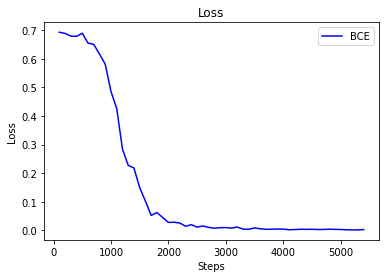

In [12]:
"""
https://www.zhihu.com/question/364113452
1. 直接将原始数据送入网络, 即输入层维度等于1.
2. 将输入转换成64位的binary code, 即输入层的维度等于64. 比如16就转换为0000000000000000000000000000000000000000000000000000000000010000这样一个向量.

方案一: 实测无效. 由于输入数据的范围过大, loss很快就到了nan, 这也就导致网络学不到任何东西, accuracy在50%左右.
方案二: 成功. accuracy达到了99%以上. 

"""

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import random

class IntDataset(Dataset):
  def __init__(self, int_len):
    self.int_len = int_len
    self._dataset_gen()

  def __len__(self):
    return self.int_len

  def __getitem__(self, idx):
    return self.dataset[idx]

  def _dataset_gen(self):
    integers = range(self.int_len)
    evens = list(integers[::2])
    odds = list(integers[1::2])

    self.dataset = list(map(lambda x: (x, 0), evens)) + list(map(lambda x: (x, 1), odds))
    random.shuffle(self.dataset)

# int to binary code
# 1-dimension to multi-dimensions
def binary(x, bits):
    mask = 2**torch.arange(bits-1,-1,-1).to(x.device, x.dtype)
    return x.unsqueeze(-1).bitwise_and(mask).ne(0).byte()

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# parameters
learning_rate = 0.1
batch_size = 10

d_in = 16
d_hidden1 = 32
d_hidden2 = 16
d_out = 1

# model
model = torch.nn.Sequential(
    nn.Linear(d_in, d_hidden1),
    nn.ReLU(),
    nn.Linear(d_hidden1, d_hidden2),
    nn.ReLU(),
    nn.Linear(d_hidden2, d_out),
    nn.Sigmoid()
)
print(model)

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# prepare dataset
n = 2000
int_dataset = IntDataset(n)
n_test = int(0.1 * n) 
test_set = torch.utils.data.Subset(int_dataset, range(n_test))  # take first 10%
train_set = torch.utils.data.Subset(int_dataset, range(n_test, n))
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

train_loss_list = []
step_list = []
def train(dataloader, model, loss_fn, optimizer, epoch_idx):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        batch = batch + 1
        x, y = x.to(device), y.to(device)
        X = binary(x, d_in).float()
        y = torch.reshape(y.float(), (batch_size, 1))
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 10 == 0:
            loss, current = loss.item(), batch*batch_size
            train_loss_list.append(loss)
            step_list.append(current + (epoch_idx* size))
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            X = binary(x, d_in).float()
            y = torch.reshape(y.float(), (batch_size, 1))
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += ((torch.abs(y-pred)<0.1)==True).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# train
epochs = 3
print(f"Train {epochs} Epochs:")
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, t)
    test(test_dataloader, model, loss_fn)
print("Done!")

# pic
plt.title("Loss")
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.plot(step_list, train_loss_list, 'b', label="BCE")
plt.legend()
plt.show()

In [ ]:
import numpy as np
import time
n =1000000
a = np.random.rand(n)
b = np.random.rand(n)

tic = time.time()
c = np.dot(a, b)
toc = time.time()

print(c)
print(f"Vectorized version: {str(1000*(toc-tic))}ms")

c= 0
tic = time.time()
for i in range(n):
  c += a[i]*b[i]
toc = time.time()

print(c)
print(f"For Loop: {str(1000*(toc-tic))}ms")

249844.86866365693
Vectorized version: 5.3501129150390625ms
249844.86866366048
For Loop: 523.2751369476318ms
